In [1]:
# Refactored code here
# Importing necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
import albumentations as A
from sklearn.metrics import confusion_matrix
from transformers import EvalPrediction, TrainingArguments, Trainer
from transformers import AutoImageProcessor, MaskFormerForInstanceSegmentation,MaskFormerImageProcessor 
import albumentations as A

from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torchvision.transforms import functional as F


c:\Users\skoka3\.conda\envs\ooga\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


bin c:\Users\skoka3\.conda\envs\ooga\Lib\site-packages\bitsandbytes\libbitsandbytes_cuda121.dll


In [2]:
# Refactored code here
processor = AutoImageProcessor.from_pretrained("facebook/maskformer-swin-base-ade")
model = MaskFormerForInstanceSegmentation.from_pretrained("facebook/maskformer-swin-base-ade")
feature_extractor = MaskFormerImageProcessor.from_pretrained("facebook/maskformer-swin-base-ade")

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
c:\Users\skoka3\.conda\envs\ooga\Lib\site-packages\transformers\models\maskformer\image_processing_maskformer.py:411: FutureWarning: The `size_divisibility` argument is deprecated and will be removed in v4.27. Please use `size_divisor` instead.
  warnings.warn(
c:\Users\skoka3\.conda\envs\ooga\Lib\site-packages\transformers\models\maskformer\image_processing_maskformer.py:418: FutureWarning: The `max_size` argument is deprecated and will be removed in v4.27. Please use size['longest_edge'] instead.
  warnings.warn(


In [3]:
# Refactored code here
def load_mask(mask_path, num_classes=7):
    # Load the mask image
    mask_image = Image.open(mask_path)
    
    # Convert mask image to numpy array
    mask_array = np.array(mask_image)
    
    # If mask is RGB, convert it to a unique class map
    if len(mask_array.shape) == 3:  # RGB image
        # Convert RGB to a unique number (assuming 8-bit per channel)
        mask = mask_array[:, :, 0] * 256 * 256 + mask_array[:, :, 1] * 256 + mask_array[:, :, 2]
        
        # Map unique RGB combinations to class indices
        unique_colors = np.unique(mask)
        color_to_class = {color: idx for idx, color in enumerate(unique_colors)}
        mask_class_map = np.vectorize(color_to_class.get)(mask)
        
        # Clip to number of classes
        mask_class_map = np.clip(mask_class_map, 0, num_classes - 1)
        
        return mask_class_map
    else:
        # If mask is already in single channel format, just return it
        return mask_array


In [4]:
# Refactored code here
class CustomImageSegmentationDataset(Dataset):
    def __init__(self, img_dir, mask_dir, img_names, augmentation=None, SIZE=1024):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.img_names = [name for name in img_names if name.lower().endswith(('.png', '.jpg', '.jpeg'))]
        self.augmentation = augmentation
        self.size = SIZE
    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_names[idx])
        mask_path = os.path.join(self.mask_dir, self.img_names[idx].replace('.jpg', '.png'))
        image = np.array(Image.open(img_path).convert("RGB"))
        mask = load_mask(mask_path)
        # SIZE = 16
        if self.augmentation:
                        # Apply a default resizing if no augmentation is provided
            resize_transform = A.Compose([A.Resize(self.size, self.size)])  # Adjust size as needed
            augmented = resize_transform(image=image, mask=mask)
            image, mask = augmented['image'], augmented['mask']
        else:
            # Apply a default resizing if no augmentation is provided
            resize_transform = A.Compose([A.Resize(self.size, self.size)])  # Adjust size as needed
            augmented = resize_transform(image=image, mask=mask)
            image, mask = augmented['image'], augmented['mask']

        image = torch.from_numpy(image).permute(2, 0, 1) / 255.0
        mask = torch.from_numpy(mask).long()

        return {"images": image, "masks": mask}
    
# Training Augmentations
def get_training_augmentation():
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        # Add more transformations as needed
    ])


In [5]:
# Refactored code here
# Disable unwanted logging (e.g., Weights & Biases)
os.environ["WANDB_DISABLED"] = "true"

# Constants and Configuration
NUM_CLASSES = 7
IMAGE_DIR = "data/imageDamage"
MASK_DIR = "data/FineDamageReducedPNG"
CHECKPOINT = "shi-labs/dinat-mini-in1k-224"
BATCH_SIZE = 4
LEARNING_RATE = 2e-4
NUM_EPOCHS = 100

In [6]:
# Refactored code here
img_names = os.listdir(IMAGE_DIR)
train_val_img_names, test_img_names = train_test_split(img_names, test_size=0.15, random_state=42)
train_img_names, valid_img_names = train_test_split(train_val_img_names, test_size=0.15, random_state=42)


# train_img_names = train_img_names[:10]
# valid_img_names = valid_img_names[:2]


train_dataset = CustomImageSegmentationDataset(
    img_dir=IMAGE_DIR,
    mask_dir=MASK_DIR,
    img_names=train_img_names,  # Slice for demonstration
    augmentation=get_training_augmentation(),
    # num_classes=NUM_CLASSES
)

valid_dataset = CustomImageSegmentationDataset(
    img_dir=IMAGE_DIR,
    mask_dir=MASK_DIR,
    img_names=valid_img_names,  # Slice for demonstration
    # num_classes=NUM_CLASSES
)


In [7]:

len(train_dataset)

807

In [8]:
def compute_miou(preds, targets, num_classes=7):
    iou_per_class = []
    for cls in range(num_classes):
        pred_inds = preds == cls
        target_inds = targets == cls
        intersection = (pred_inds[target_inds]).long().sum().item()  # Intersection
        union = pred_inds.long().sum().item() + target_inds.long().sum().item() - intersection  # Union
        if union == 0:
            iou_per_class.append(float('nan'))  # Avoid division by zero
        else:
            iou_per_class.append(float(intersection) / float(max(union, 1)))
    return np.nanmean(iou_per_class)  # Mean IoU

def resize_mask(mask, size):
    return F.resize(mask, size, interpolation=F.InterpolationMode.NEAREST)


In [9]:
# Load model and processor
processor = AutoImageProcessor.from_pretrained("facebook/maskformer-swin-base-ade")
model = MaskFormerForInstanceSegmentation.from_pretrained("facebook/maskformer-swin-base-ade")
model.to('cuda')  # Move model to GPU if available

# Assuming you have a PyTorch Dataset for your data
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)
# Define the optimizer and loss function
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
criterion = CrossEntropyLoss()

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [10]:
# # data = train_loader.dataset.data 
# shape = train_loader.dataset.data.shape  
# # datatype = train_loader.dataset.data.dtype

In [11]:
from tqdm import tqdm
training_losses = []
validation_losses = []
train_miou_scores = []  # Store training mIoU scores
miou_scores = []  # Store validation mIoU scores
best_validation_loss = float('inf')
best_miou = 0

for epoch in range(NUM_EPOCHS):
    model.train()
    train_loss = 0
    train_miou = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} - Training"):
        images, masks = batch['images'].to('cuda'), batch['masks'].to('cuda')
        inputs = processor(images=images, return_tensors="pt").to('cuda')
        outputs = model(**inputs)
        masks_logits = outputs.masks_queries_logits
        target_size = masks_logits.shape[-2:]
        resized_masks = resize_mask(masks, target_size)
        loss = criterion(masks_logits, resized_masks)
        preds = torch.argmax(masks_logits, dim=1)
        train_miou += compute_miou(preds, resized_masks, num_classes=7)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    training_losses.append(train_loss / len(train_loader))
    avg_train_miou = train_miou / len(train_loader)
    train_miou_scores.append(avg_train_miou)

    model.eval()
    val_loss = 0
    val_miou = 0
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} - Validation"):
            images, masks = batch['images'].to('cuda'), batch['masks'].to('cuda')
            inputs = processor(images=images, return_tensors="pt").to('cuda')
            outputs = model(**inputs)
            masks_logits = outputs.masks_queries_logits
            resized_masks = resize_mask(masks, target_size)
            preds = torch.argmax(masks_logits, dim=1)


            val_loss += criterion(masks_logits, resized_masks).item()
            val_miou += compute_miou(preds, resized_masks, num_classes=7)

        # Calculate and store average validation loss and mIoU
        avg_val_loss = val_loss / len(val_loader)
        avg_val_miou = val_miou / len(val_loader)
        validation_losses.append(avg_val_loss)
        miou_scores.append(avg_val_miou)

            # Print epoch summary
        print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Training Loss: {training_losses[-1]}, Training mIoU: {avg_train_miou}, Validation Loss: {validation_losses[-1]}, mIoU: {miou_scores[-1]}")


            # Check for best validation loss and best mIoU after processing all batches
        if avg_val_loss < best_validation_loss:
            best_validation_loss = avg_val_loss
            # torch.save(model.state_dict(), f"best_loss_model_maskformer_loss{avg_val_loss:.2f}.pth")
            model.save_pretrained("best_maskformer_loss")

        if avg_val_miou > best_miou:
            best_miou = avg_val_miou
            # torch.save(model.state_dict(), f"best_miou_model_maskformer_miou{avg_val_miou:.2f}.pth")
            model.save_pretrained("best_maskformer_iou")


    # Save the final model
    # torch.save(model.state_dict(), "best_maskformer.pth")
    model.save_pretrained("best_maskformer")



Epoch 1/100 - Validation: 100%|██████████| 36/36 [00:19<00:00,  1.84it/s]


Epoch 1/100, Training Loss: 0.38130891325855903, Training mIoU: 0.22781603474448728, Validation Loss: 0.06098894805957874, mIoU: 0.23194477448640047


Epoch 2/100 - Validation: 100%|██████████| 36/36 [00:19<00:00,  1.85it/s]


Epoch 2/100, Training Loss: 0.06523402777989165, Training mIoU: 0.24408182202497583, Validation Loss: 0.05980325679087804, mIoU: 0.23926199905960654


Epoch 3/100 - Validation: 100%|██████████| 36/36 [00:19<00:00,  1.88it/s]


Epoch 3/100, Training Loss: 0.06435465062092437, Training mIoU: 0.2432413277704723, Validation Loss: 0.06043362276007732, mIoU: 0.23969162778501157


Epoch 4/100 - Validation: 100%|██████████| 36/36 [00:19<00:00,  1.88it/s]


Epoch 4/100, Training Loss: 0.06302543615203092, Training mIoU: 0.24382043228736924, Validation Loss: 0.05603632822425829, mIoU: 0.23975912663966048


Epoch 5/100 - Validation: 100%|██████████| 36/36 [00:19<00:00,  1.88it/s]


Epoch 5/100, Training Loss: 0.06233518958405251, Training mIoU: 0.24225572884436877, Validation Loss: 0.056617269654654793, mIoU: 0.23285163483796298


Epoch 6/100 - Validation: 100%|██████████| 36/36 [00:19<00:00,  1.88it/s]


Epoch 6/100, Training Loss: 0.06303489088809283, Training mIoU: 0.2429268029341997, Validation Loss: 0.05688320240005851, mIoU: 0.24064467592592592


Epoch 7/100 - Validation: 100%|██████████| 36/36 [00:19<00:00,  1.87it/s]


Epoch 7/100, Training Loss: 0.062298873006043455, Training mIoU: 0.24284056650293953, Validation Loss: 0.05857293654440178, mIoU: 0.23372100151909725


Epoch 8/100 - Validation: 100%|██████████| 36/36 [00:19<00:00,  1.88it/s]


Epoch 8/100, Training Loss: 0.06193925827133036, Training mIoU: 0.24331777359864892, Validation Loss: 0.056821365064630903, mIoU: 0.23788921139564043


Epoch 9/100 - Validation: 100%|██████████| 36/36 [00:19<00:00,  1.87it/s]


Epoch 9/100, Training Loss: 0.06207427748543496, Training mIoU: 0.24251729933735566, Validation Loss: 0.06265689173920287, mIoU: 0.23469969798900467


Epoch 10/100 - Validation: 100%|██████████| 36/36 [00:19<00:00,  1.88it/s]


Epoch 10/100, Training Loss: 0.06423895479650191, Training mIoU: 0.24577059241568683, Validation Loss: 0.057955438995526895, mIoU: 0.2319118787977431


Epoch 11/100 - Validation: 100%|██████████| 36/36 [00:19<00:00,  1.88it/s]


Epoch 11/100, Training Loss: 0.0642396161646241, Training mIoU: 0.24440891567184056, Validation Loss: 0.05954928447802862, mIoU: 0.23418804253472217


Epoch 12/100 - Validation: 100%|██████████| 36/36 [00:19<00:00,  1.86it/s]


Epoch 12/100, Training Loss: 0.06257184493438442, Training mIoU: 0.24539953734142947, Validation Loss: 0.05654327793874674, mIoU: 0.23281733760127313


Epoch 13/100 - Validation: 100%|██████████| 36/36 [00:19<00:00,  1.87it/s]


Epoch 13/100, Training Loss: 0.06193462989320702, Training mIoU: 0.24447392529780318, Validation Loss: 0.060980176268559366, mIoU: 0.22912490505642363


Epoch 14/100 - Validation: 100%|██████████| 36/36 [00:19<00:00,  1.86it/s]


Epoch 14/100, Training Loss: 0.06369947022435689, Training mIoU: 0.2412699744095504, Validation Loss: 0.06043204934232765, mIoU: 0.23835859284577549


Epoch 15/100 - Validation: 100%|██████████| 36/36 [00:19<00:00,  1.88it/s]


Epoch 15/100, Training Loss: 0.0630442313204455, Training mIoU: 0.24430852042723797, Validation Loss: 0.05628108874791198, mIoU: 0.23696430573640045


Epoch 16/100 - Validation: 100%|██████████| 36/36 [00:19<00:00,  1.87it/s]


Epoch 16/100, Training Loss: 0.06218094291571196, Training mIoU: 0.2442329858962459, Validation Loss: 0.056508818434344396, mIoU: 0.23741732825761958


Epoch 17/100 - Validation: 100%|██████████| 36/36 [00:19<00:00,  1.87it/s]


Epoch 17/100, Training Loss: 0.062422074792482476, Training mIoU: 0.24484056880506672, Validation Loss: 0.06361170692576303, mIoU: 0.23650163815345293


Epoch 18/100 - Validation: 100%|██████████| 36/36 [00:19<00:00,  1.88it/s]


Epoch 18/100, Training Loss: 0.062224904918987856, Training mIoU: 0.23818277672493812, Validation Loss: 0.05651278214322196, mIoU: 0.23836648220486112


Epoch 19/100 - Validation: 100%|██████████| 36/36 [00:19<00:00,  1.87it/s]


Epoch 19/100, Training Loss: 0.06185761182154022, Training mIoU: 0.2416940055821989, Validation Loss: 0.05700608777503172, mIoU: 0.23187078631365743


Epoch 20/100 - Validation: 100%|██████████| 36/36 [00:19<00:00,  1.87it/s]


Epoch 20/100, Training Loss: 0.06181293119224581, Training mIoU: 0.2444760629383252, Validation Loss: 0.05603929702192545, mIoU: 0.23653235767505792


Epoch 21/100 - Validation: 100%|██████████| 36/36 [00:19<00:00,  1.87it/s]


Epoch 21/100, Training Loss: 0.0613247244572728, Training mIoU: 0.24449278455677598, Validation Loss: 0.057565690846078925, mIoU: 0.2406097276475695


Epoch 22/100 - Validation: 100%|██████████| 36/36 [00:19<00:00,  1.87it/s]


Epoch 22/100, Training Loss: 0.06221360749666496, Training mIoU: 0.24267824763433382, Validation Loss: 0.05658359556562371, mIoU: 0.23233598873939043


Epoch 23/100 - Validation: 100%|██████████| 36/36 [00:19<00:00,  1.87it/s]


Epoch 23/100, Training Loss: 0.06202274769784348, Training mIoU: 0.24354221215578603, Validation Loss: 0.05836810215583278, mIoU: 0.23003726309317127


Epoch 24/100 - Validation: 100%|██████████| 36/36 [00:19<00:00,  1.86it/s]


Epoch 24/100, Training Loss: 0.061948697940252796, Training mIoU: 0.24005963638356004, Validation Loss: 0.05724325698489944, mIoU: 0.23466086154513896


Epoch 25/100 - Validation: 100%|██████████| 36/36 [00:19<00:00,  1.86it/s]


Epoch 25/100, Training Loss: 0.06194939603106958, Training mIoU: 0.24169106730008927, Validation Loss: 0.05622444265625543, mIoU: 0.22591903573495373


Epoch 26/100 - Validation: 100%|██████████| 36/36 [00:19<00:00,  1.87it/s]


Epoch 26/100, Training Loss: 0.06121273959369058, Training mIoU: 0.24389990073226064, Validation Loss: 0.05606406544231706, mIoU: 0.23421163375289356


Epoch 27/100 - Validation: 100%|██████████| 36/36 [00:19<00:00,  1.87it/s]


Epoch 27/100, Training Loss: 0.06188724412223195, Training mIoU: 0.24358782777691834, Validation Loss: 0.05919130700122979, mIoU: 0.23229474555121524


Epoch 28/100 - Validation: 100%|██████████| 36/36 [00:19<00:00,  1.87it/s]


Epoch 28/100, Training Loss: 0.06225349603792523, Training mIoU: 0.24268860306440793, Validation Loss: 0.056516755268805556, mIoU: 0.23234690574363417


Epoch 29/100 - Validation: 100%|██████████| 36/36 [00:19<00:00,  1.87it/s]


Epoch 29/100, Training Loss: 0.0620344675533326, Training mIoU: 0.24269561062551584, Validation Loss: 0.05793133227982455, mIoU: 0.23879796609760806


Epoch 30/100 - Validation: 100%|██████████| 36/36 [00:19<00:00,  1.87it/s]


Epoch 30/100, Training Loss: 0.061926137554542265, Training mIoU: 0.24469685308374592, Validation Loss: 0.05680571786231465, mIoU: 0.23235648148148144


Epoch 31/100 - Validation: 100%|██████████| 36/36 [00:19<00:00,  1.87it/s]


Epoch 31/100, Training Loss: 0.0616615466764289, Training mIoU: 0.2405363012131291, Validation Loss: 0.056131429970264435, mIoU: 0.23740075985001927


Epoch 32/100 - Validation: 100%|██████████| 36/36 [00:19<00:00,  1.87it/s]


Epoch 32/100, Training Loss: 0.06135940010484198, Training mIoU: 0.24530085860148518, Validation Loss: 0.05684171456636654, mIoU: 0.2369905553747107


Epoch 33/100 - Validation: 100%|██████████| 36/36 [00:19<00:00,  1.87it/s]


Epoch 33/100, Training Loss: 0.06173708295394288, Training mIoU: 0.2433742514632321, Validation Loss: 0.0566307763931238, mIoU: 0.23641813904562112


Epoch 34/100 - Validation: 100%|██████████| 36/36 [00:19<00:00,  1.87it/s]


Epoch 34/100, Training Loss: 0.0611831945099748, Training mIoU: 0.2414631492690286, Validation Loss: 0.057192254501084484, mIoU: 0.22916933865017367


Epoch 35/100 - Validation: 100%|██████████| 36/36 [00:19<00:00,  1.87it/s]


Epoch 35/100, Training Loss: 0.0613684511771149, Training mIoU: 0.24284538163288974, Validation Loss: 0.056610797738863364, mIoU: 0.22913423213252315


Epoch 36/100 - Validation: 100%|██████████| 36/36 [00:19<00:00,  1.88it/s]


Epoch 36/100, Training Loss: 0.061683465205686225, Training mIoU: 0.24210869575727098, Validation Loss: 0.05636536805993981, mIoU: 0.23878644024884263


Epoch 37/100 - Validation: 100%|██████████| 36/36 [00:19<00:00,  1.88it/s]


Epoch 37/100, Training Loss: 0.06128954718645552, Training mIoU: 0.2418456281907488, Validation Loss: 0.056240986877431474, mIoU: 0.236960363317419


Epoch 38/100 - Validation: 100%|██████████| 36/36 [00:19<00:00,  1.88it/s]


Epoch 38/100, Training Loss: 0.06073623767473025, Training mIoU: 0.24452012132365578, Validation Loss: 0.05633209837186667, mIoU: 0.2342031521267361


Epoch 39/100 - Validation: 100%|██████████| 36/36 [00:19<00:00,  1.87it/s]


Epoch 39/100, Training Loss: 0.06170682479525999, Training mIoU: 0.2438864947529909, Validation Loss: 0.05620302570362886, mIoU: 0.2323181920934606


Epoch 40/100 - Validation: 100%|██████████| 36/36 [00:19<00:00,  1.88it/s]


Epoch 40/100, Training Loss: 0.06142835238358319, Training mIoU: 0.24423927151015898, Validation Loss: 0.06068339157435629, mIoU: 0.2369906231915509


Epoch 41/100 - Validation: 100%|██████████| 36/36 [00:19<00:00,  1.88it/s]


Epoch 41/100, Training Loss: 0.06146374682314915, Training mIoU: 0.24106222201810018, Validation Loss: 0.057162841937194266, mIoU: 0.23557509584780092


Epoch 42/100 - Validation: 100%|██████████| 36/36 [00:19<00:00,  1.86it/s]


Epoch 42/100, Training Loss: 0.06163732135797491, Training mIoU: 0.24464645697968246, Validation Loss: 0.05610767832129366, mIoU: 0.23214639201492218


Epoch 43/100 - Validation: 100%|██████████| 36/36 [00:19<00:00,  1.87it/s]


Epoch 43/100, Training Loss: 0.20578791573182634, Training mIoU: 0.23778845307475951, Validation Loss: 0.13064813882940346, mIoU: 0.23235011574074077


Epoch 44/100 - Validation: 100%|██████████| 36/36 [00:19<00:00,  1.87it/s]


Epoch 44/100, Training Loss: 0.06939334657946879, Training mIoU: 0.24192245352464936, Validation Loss: 0.056319731287658215, mIoU: 0.23186539713541668


Epoch 45/100 - Validation: 100%|██████████| 36/36 [00:19<00:00,  1.87it/s]


Epoch 45/100, Training Loss: 0.06356293483554284, Training mIoU: 0.2460946065065491, Validation Loss: 0.05879291876529654, mIoU: 0.2341610514322916


Epoch 46/100 - Validation: 100%|██████████| 36/36 [00:19<00:00,  1.87it/s]


Epoch 46/100, Training Loss: 0.06180358781838919, Training mIoU: 0.2448917490137686, Validation Loss: 0.056349196885195046, mIoU: 0.23418655960648144


Epoch 47/100 - Validation: 100%|██████████| 36/36 [00:19<00:00,  1.86it/s]


Epoch 47/100, Training Loss: 0.06145184223844421, Training mIoU: 0.24554118402562902, Validation Loss: 0.06170338340517548, mIoU: 0.23149098488136577


Epoch 48/100 - Validation: 100%|██████████| 36/36 [00:19<00:00,  1.87it/s]


Epoch 48/100, Training Loss: 0.06229436949430273, Training mIoU: 0.2443005072968235, Validation Loss: 0.05655251981483565, mIoU: 0.2336879973234954


Epoch 49/100 - Validation: 100%|██████████| 36/36 [00:19<00:00,  1.87it/s]


Epoch 49/100, Training Loss: 0.061435608829528386, Training mIoU: 0.24439232592692853, Validation Loss: 0.05814010158388151, mIoU: 0.23376053421585652


Epoch 50/100 - Validation: 100%|██████████| 36/36 [00:19<00:00,  1.87it/s]


Epoch 50/100, Training Loss: 0.06132211273370108, Training mIoU: 0.24338755188995465, Validation Loss: 0.056162673979997635, mIoU: 0.2374142659505209


Epoch 51/100 - Validation: 100%|██████████| 36/36 [00:19<00:00,  1.86it/s]


Epoch 51/100, Training Loss: 0.0620601225026542, Training mIoU: 0.2426804046127269, Validation Loss: 0.05636802144969503, mIoU: 0.23004649522569454


Epoch 52/100 - Validation: 100%|██████████| 36/36 [00:19<00:00,  1.87it/s]


Epoch 52/100, Training Loss: 0.061254214066643234, Training mIoU: 0.24341593102181308, Validation Loss: 0.05615771892997953, mIoU: 0.23649455204716435


Epoch 53/100 - Validation: 100%|██████████| 36/36 [00:19<00:00,  1.87it/s]


Epoch 53/100, Training Loss: 0.061247391709227966, Training mIoU: 0.24412048403152262, Validation Loss: 0.05709879224499067, mIoU: 0.23374728280526613


Epoch 54/100 - Validation: 100%|██████████| 36/36 [00:19<00:00,  1.87it/s]


Epoch 54/100, Training Loss: 0.06035829940349749, Training mIoU: 0.24461533536166102, Validation Loss: 0.05685727308607764, mIoU: 0.2406420988859954


Epoch 55/100 - Validation: 100%|██████████| 36/36 [00:19<00:00,  1.87it/s]


Epoch 55/100, Training Loss: 0.06167459792208554, Training mIoU: 0.2397617139155321, Validation Loss: 0.05631152426617013, mIoU: 0.23787199345341437


Epoch 56/100 - Validation: 100%|██████████| 36/36 [00:19<00:00,  1.86it/s]


Epoch 56/100, Training Loss: 0.06141967987549482, Training mIoU: 0.24054534891965762, Validation Loss: 0.05666936173414191, mIoU: 0.2397111590350116


Epoch 57/100 - Validation: 100%|██████████| 36/36 [00:19<00:00,  1.88it/s]


Epoch 57/100, Training Loss: 0.06076913891765889, Training mIoU: 0.24291633469987636, Validation Loss: 0.05616764905345109, mIoU: 0.2328261357060185


Epoch 58/100 - Validation: 100%|██████████| 36/36 [00:19<00:00,  1.87it/s]


Epoch 58/100, Training Loss: 0.06111598014831543, Training mIoU: 0.24586619965707493, Validation Loss: 0.05654136766679585, mIoU: 0.23336093026620372


Epoch 59/100 - Validation: 100%|██████████| 36/36 [00:19<00:00,  1.87it/s]


Epoch 59/100, Training Loss: 0.0612108229779371, Training mIoU: 0.24070647206322202, Validation Loss: 0.05649299810950955, mIoU: 0.2355495017722801


Epoch 60/100 - Validation: 100%|██████████| 36/36 [00:19<00:00,  1.86it/s]


Epoch 60/100, Training Loss: 0.06128496879084718, Training mIoU: 0.24594462117110139, Validation Loss: 0.05603782423875398, mIoU: 0.23925855999228388


Epoch 61/100 - Validation: 100%|██████████| 36/36 [00:19<00:00,  1.88it/s]


Epoch 61/100, Training Loss: 0.06111949934891545, Training mIoU: 0.24386826880930274, Validation Loss: 0.05649807925025622, mIoU: 0.23738546187789356


Epoch 62/100 - Validation: 100%|██████████| 36/36 [00:19<00:00,  1.88it/s]


Epoch 62/100, Training Loss: 0.06074885510387692, Training mIoU: 0.2437246515423026, Validation Loss: 0.05683409976255563, mIoU: 0.23420747432002317


Epoch 63/100 - Validation: 100%|██████████| 36/36 [00:19<00:00,  1.86it/s]


Epoch 63/100, Training Loss: 0.06116800257327533, Training mIoU: 0.2442169096792491, Validation Loss: 0.0576965706422925, mIoU: 0.23653534161603007


Epoch 64/100 - Validation: 100%|██████████| 36/36 [00:19<00:00,  1.86it/s]


Epoch 64/100, Training Loss: 0.06099009772504468, Training mIoU: 0.24273433954723583, Validation Loss: 0.05818092331497206, mIoU: 0.23186611599392362


Epoch 65/100 - Validation: 100%|██████████| 36/36 [00:19<00:00,  1.87it/s]


Epoch 65/100, Training Loss: 0.06068088504310587, Training mIoU: 0.24078921800871483, Validation Loss: 0.05594426305550668, mIoU: 0.22918957067418985


Epoch 66/100 - Validation: 100%|██████████| 36/36 [00:19<00:00,  1.87it/s]


Epoch 66/100, Training Loss: 0.06124694362319637, Training mIoU: 0.24433237772019378, Validation Loss: 0.05599617911502719, mIoU: 0.23189914731626157


Epoch 67/100 - Validation: 100%|██████████| 36/36 [00:19<00:00,  1.87it/s]


Epoch 67/100, Training Loss: 0.06088877662942551, Training mIoU: 0.23937650996544974, Validation Loss: 0.057649604665736355, mIoU: 0.24198131872106485


Epoch 68/100 - Validation: 100%|██████████| 36/36 [00:19<00:00,  1.87it/s]


Epoch 68/100, Training Loss: 0.06131477793217591, Training mIoU: 0.24042860457920798, Validation Loss: 0.05686384439468384, mIoU: 0.23418612105758102


Epoch 69/100 - Validation: 100%|██████████| 36/36 [00:19<00:00,  1.86it/s]


Epoch 69/100, Training Loss: 0.06069337797471055, Training mIoU: 0.24232232175854293, Validation Loss: 0.06050470160941283, mIoU: 0.24009301908516584


Epoch 70/100 - Validation: 100%|██████████| 36/36 [00:19<00:00,  1.88it/s]


Epoch 70/100, Training Loss: 0.061220475380299705, Training mIoU: 0.24241742728960383, Validation Loss: 0.05668046077092489, mIoU: 0.23919603587962956


Epoch 71/100 - Validation: 100%|██████████| 36/36 [00:19<00:00,  1.87it/s]


Epoch 71/100, Training Loss: 0.06161083200817356, Training mIoU: 0.24529711511190186, Validation Loss: 0.05607833940949705, mIoU: 0.22733325195312495


Epoch 72/100 - Validation: 100%|██████████| 36/36 [00:19<00:00,  1.87it/s]


Epoch 72/100, Training Loss: 0.06106050166827027, Training mIoU: 0.2426534750154703, Validation Loss: 0.07489387566844623, mIoU: 0.23235215476707177


Epoch 73/100 - Validation: 100%|██████████| 36/36 [00:18<00:00,  1.91it/s]


Epoch 73/100, Training Loss: 0.06186493904339058, Training mIoU: 0.2415179294296616, Validation Loss: 0.05690946554144224, mIoU: 0.23604405834056708


Epoch 74/100 - Validation: 100%|██████████| 36/36 [00:18<00:00,  1.91it/s]


Epoch 74/100, Training Loss: 0.061070970646889496, Training mIoU: 0.24480815220193888, Validation Loss: 0.05673182295221421, mIoU: 0.2419516149450232


Epoch 75/100 - Validation: 100%|██████████| 36/36 [00:18<00:00,  1.92it/s]


Epoch 75/100, Training Loss: 0.06130451060794663, Training mIoU: 0.24020049988397263, Validation Loss: 0.056142077833000154, mIoU: 0.23921754738136583


Epoch 76/100 - Validation: 100%|██████████| 36/36 [00:18<00:00,  1.92it/s]


Epoch 76/100, Training Loss: 0.06063659303812402, Training mIoU: 0.24308396584287337, Validation Loss: 0.059038720197147794, mIoU: 0.2300239122178819


Epoch 77/100 - Validation: 100%|██████████| 36/36 [00:18<00:00,  1.91it/s]


Epoch 77/100, Training Loss: 0.06118514215905625, Training mIoU: 0.24095184547751658, Validation Loss: 0.056643318126185074, mIoU: 0.23241123679832176


Epoch 78/100 - Validation: 100%|██████████| 36/36 [00:18<00:00,  1.91it/s]


Epoch 78/100, Training Loss: 0.061232604971616575, Training mIoU: 0.24355402034344054, Validation Loss: 0.05622916994616389, mIoU: 0.24020437735098385


Epoch 79/100 - Validation: 100%|██████████| 36/36 [00:18<00:00,  1.92it/s]


Epoch 79/100, Training Loss: 0.1922099278170136, Training mIoU: 0.23602961934505098, Validation Loss: 0.06874575393481387, mIoU: 0.22548560474537035


Epoch 80/100 - Validation: 100%|██████████| 36/36 [00:18<00:00,  1.91it/s]


Epoch 80/100, Training Loss: 0.1546858060588636, Training mIoU: 0.23539922783943937, Validation Loss: 0.06344208845661746, mIoU: 0.23186461046006934


Epoch 81/100 - Validation: 100%|██████████| 36/36 [00:18<00:00,  1.90it/s]


Epoch 81/100, Training Loss: 0.06746976902837505, Training mIoU: 0.2452970595155218, Validation Loss: 0.05852511194017199, mIoU: 0.23514914731626158


Epoch 82/100 - Validation: 100%|██████████| 36/36 [00:18<00:00,  1.91it/s]


Epoch 82/100, Training Loss: 0.06414992418509013, Training mIoU: 0.24332374926945838, Validation Loss: 0.06367815668798155, mIoU: 0.23369797996238428


Epoch 83/100 - Validation: 100%|██████████| 36/36 [00:18<00:00,  1.92it/s]


Epoch 83/100, Training Loss: 0.06357683969827571, Training mIoU: 0.24366927083333326, Validation Loss: 0.05747533170506358, mIoU: 0.23509900806568287


Epoch 84/100 - Validation: 100%|██████████| 36/36 [00:18<00:00,  1.91it/s]


Epoch 84/100, Training Loss: 0.06272495900382205, Training mIoU: 0.2443017626469677, Validation Loss: 0.057983556400156684, mIoU: 0.2309622893156829


Epoch 85/100 - Validation: 100%|██████████| 36/36 [00:18<00:00,  1.91it/s]


Epoch 85/100, Training Loss: 0.0628062746542884, Training mIoU: 0.23971748820389863, Validation Loss: 0.057228617577089205, mIoU: 0.23605208785445597


Epoch 86/100 - Validation: 100%|██████████| 36/36 [00:18<00:00,  1.92it/s]


Epoch 86/100, Training Loss: 0.06162171842216855, Training mIoU: 0.24127059483292077, Validation Loss: 0.056967176186541714, mIoU: 0.23557717556423619


Epoch 87/100 - Validation: 100%|██████████| 36/36 [00:18<00:00,  1.91it/s]


Epoch 87/100, Training Loss: 0.06242400838412566, Training mIoU: 0.23849107476665662, Validation Loss: 0.05685895037216445, mIoU: 0.23264951934007114


Epoch 88/100 - Validation: 100%|██████████| 36/36 [00:18<00:00,  1.92it/s]


Epoch 88/100, Training Loss: 0.06156804235559879, Training mIoU: 0.24508939495023704, Validation Loss: 0.056589220081352525, mIoU: 0.2332552897135417


Epoch 89/100 - Validation: 100%|██████████| 36/36 [00:18<00:00,  1.91it/s]


Epoch 89/100, Training Loss: 0.062242451317534586, Training mIoU: 0.24436000589805074, Validation Loss: 0.056924946787249714, mIoU: 0.2365256799768519


Epoch 90/100 - Validation: 100%|██████████| 36/36 [00:18<00:00,  1.91it/s]


Epoch 90/100, Training Loss: 0.06282254061799976, Training mIoU: 0.24052233255552136, Validation Loss: 0.05941415883393751, mIoU: 0.2300924750434028


Epoch 91/100 - Validation: 100%|██████████| 36/36 [00:18<00:00,  1.91it/s]


Epoch 91/100, Training Loss: 0.06889283103351988, Training mIoU: 0.2449096839491543, Validation Loss: 0.08088360245650013, mIoU: 0.23277081524884258


Epoch 92/100 - Validation: 100%|██████████| 36/36 [00:18<00:00,  1.92it/s]


Epoch 92/100, Training Loss: 0.06389945189901951, Training mIoU: 0.24298267649030525, Validation Loss: 0.06571778582615985, mIoU: 0.23326712149160883


Epoch 93/100 - Validation: 100%|██████████| 36/36 [00:18<00:00,  1.92it/s]


Epoch 93/100, Training Loss: 0.06171170469041508, Training mIoU: 0.24103388961943067, Validation Loss: 0.05785676511004567, mIoU: 0.23972983127170133


Epoch 94/100 - Validation: 100%|██████████| 36/36 [00:18<00:00,  1.92it/s]


Epoch 94/100, Training Loss: 0.06148519281224154, Training mIoU: 0.24225953276479995, Validation Loss: 0.05665596802201536, mIoU: 0.23738911494502313


Epoch 95/100 - Validation: 100%|██████████| 36/36 [00:18<00:00,  1.91it/s]


Epoch 95/100, Training Loss: 0.061516634396065285, Training mIoU: 0.2406229912786201, Validation Loss: 0.05612555153978368, mIoU: 0.23373867006655097


Epoch 96/100 - Validation: 100%|██████████| 36/36 [00:18<00:00,  1.91it/s]


Epoch 96/100, Training Loss: 0.06311523249501934, Training mIoU: 0.24233575781894584, Validation Loss: 0.056089462298485965, mIoU: 0.23284329939477239


Epoch 97/100 - Validation: 100%|██████████| 36/36 [00:18<00:00,  1.91it/s]


Epoch 97/100, Training Loss: 0.06112443899164106, Training mIoU: 0.24517481999664806, Validation Loss: 0.05707316975005799, mIoU: 0.23186414478443287


Epoch 98/100 - Validation: 100%|██████████| 36/36 [00:18<00:00,  1.90it/s]


Epoch 98/100, Training Loss: 0.06115553374310015, Training mIoU: 0.24447212445853964, Validation Loss: 0.056888469546619386, mIoU: 0.2378204511477623


Epoch 99/100 - Validation: 100%|██████████| 36/36 [00:19<00:00,  1.89it/s]


Epoch 99/100, Training Loss: 0.060463810339570045, Training mIoU: 0.24300109178398296, Validation Loss: 0.05957989084223906, mIoU: 0.23328815827546295


Epoch 100/100 - Validation: 100%|██████████| 36/36 [00:18<00:00,  1.90it/s]


Epoch 100/100, Training Loss: 0.060761835020367465, Training mIoU: 0.24570683303681937, Validation Loss: 0.05740284873172641, mIoU: 0.23515342881944445


In [12]:
model.save_pretrained("best_maskformer_iou")


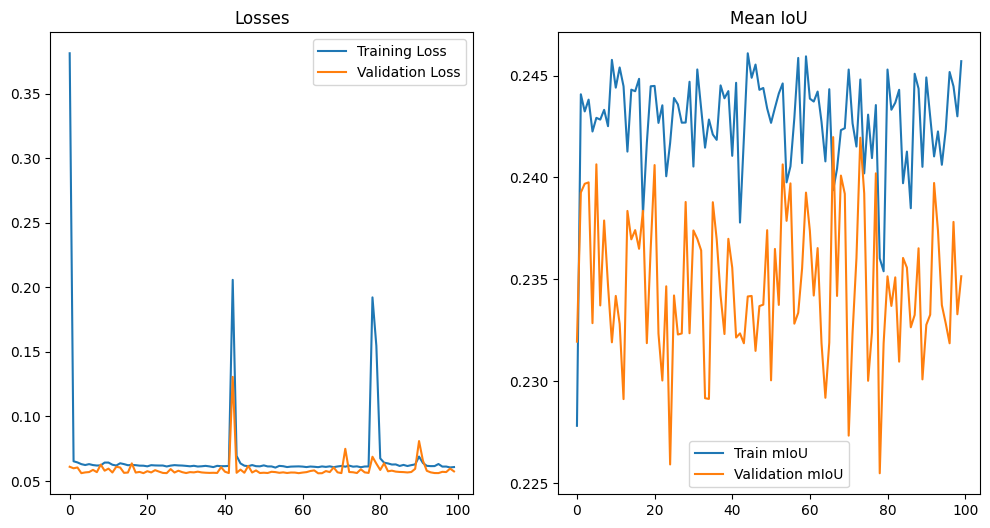

In [13]:
# Plotting
plt.figure(figsize=(12, 6))

# Plotting Losses
plt.subplot(1, 2, 1)
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.title('Losses')
plt.legend()

# Plotting mIoU
plt.subplot(1, 2, 2)
plt.plot(train_miou_scores, label='Train mIoU')  # Plot training mIoU
plt.plot(miou_scores, label='Validation mIoU')  # Plot validation mIoU
plt.title('Mean IoU')
plt.legend()

In [14]:
from transformers import AutoImageProcessor, MaskFormerModel
from PIL import Image
import requests

# load MaskFormer fine-tuned on ADE20k semantic segmentation
image_processor = AutoImageProcessor.from_pretrained("facebook/maskformer-swin-base-ade")
model = MaskFormerModel.from_pretrained("best_maskformer")


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


Labels in the mask: {0: 'Background', 2: 'Class 2', 3: 'Unknown'}


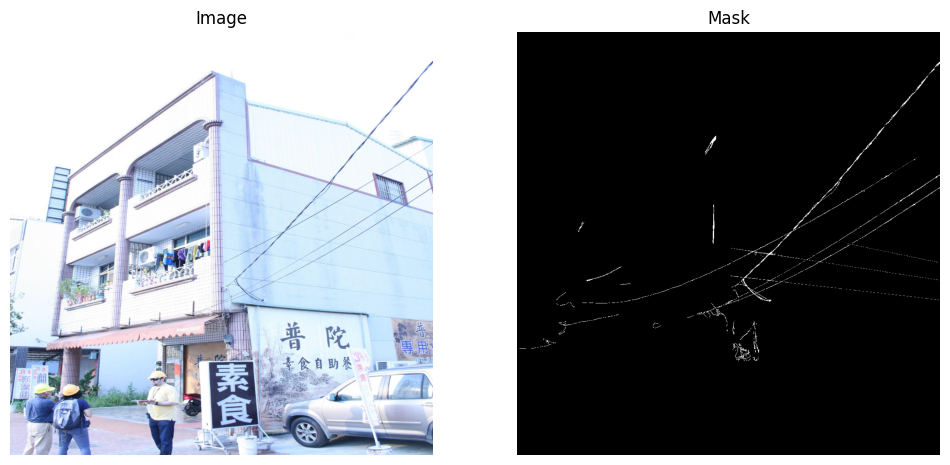

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Define paths and other necessary variables
image_dir = IMAGE_DIR  # specify the path to your image directory
mask_dir = MASK_DIR   # specify the path to your mask directory
img_names = test_img_names  # replace with your list of image names

# Instantiate your dataset
dataset = CustomImageSegmentationDataset(
    img_dir=image_dir,
    mask_dir=mask_dir,
    img_names=test_img_names,
    augmentation=get_training_augmentation()
)

# Fetch an image and its mask (change index to view different images)
data = dataset[15]
image = data['images'].permute(1, 2, 0).numpy()  # Convert tensor to numpy array and adjust dimensions
mask = data['masks'].numpy()  # Convert mask tensor to numpy array

# Create a function to visualize the image and mask
def visualize_image_and_mask(image, mask, labels=None):
    plt.figure(figsize=(12, 6))

    # Display the image
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Image')
    plt.axis('off')

    # Display the mask
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')  # Use grayscale colormap
    plt.title('Mask')
    plt.axis('off')

    # Display labels if provided
    if labels:
        unique_labels = np.unique(mask)
        labeled_masks = {label: labels.get(label, 'Unknown') for label in unique_labels}
        print("Labels in the mask:", labeled_masks)

    plt.show()

# Define your class labels (if available)
labels_dict = {
    0: 'Background',
    1: 'Class 1',
    2: 'Class 2',
    # Add additional labels for your classes
}

# Visualize the image and its mask
visualize_image_and_mask(image, mask, labels=labels_dict)
